<table>
    <tr>
        <td><img src="./imagenes/Macc.png" width="400"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="color:blue;text-align:left">Inteligencia Artificial</h1></td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Notebook 3</p></tp>
            <tp><p style="font-size:150%;text-align:center">Búsqueda en espacio de estados (2/3) </p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

## Objetivo

En este notebook vamos a expandir el abanico de algoritmos de búsqueda a ciegas en un espacio de estados y luego vamos a incluir la consideración del costo del camino a seguir. 

Comenzaremos implementando los algoritmos `depth_limited_search` e `iterative_deepening_search` y los aplicaremos a la solución de problemas. 

A continuación, para poder considerar el costo del camino a seguir, vamos a 
definir una lista prioritaria y mostraremos una posible implementación en Python. Analizaremos también la manera en la cual tanto el ambiente de tarea como el árbol de busqueda involucran el costo de las acciones. 

Posteriormente, definiremos el algoritmo general de búsqueda basada en funciones de evaluación, llamado `best_first_search` para encontrar la solución más eficiente en el problema de las jarras de agua.

Finalmente, usaremos los cuatro métodos para comparar su eficiencia en la búsqueda de una solución para el problema del laberinto.

Adaptado de (Russell & Norvig, 2020), secciones 3.3 y 3.4.4.

## Secciones

Desarrollaremos la explicación de la siguiente manera:

* [Estrategia de búsqueda depth limited](#limited).
* [Estrategia de búsqueda iterative deepening](#iterative).
* [Listas prioritarias](#listas).
* [Costos](#costos).
* [Estrategia de búsqueda best first search](#best).
* [Problema del laberinto](#laberinto).



## Depth limited search <a class="anchor" id="limited"></a>
    
En el notebook anterior hemos visto un algoritmo recursivo de `backtracking_search` que funcionaba bien en el caso de las 8 reinas, pero que superaba el umbral de memoria en el problema de las jarras de agua. Esta dificultad residía en el hecho de que el camino de búsqueda puede generar ciclos, lo cual conlleva a que el algoritmo se quede atascado en un bucle infinito. La solución que dimos en su momento fue el algoritmo `depth_first_search`, el cual lleva la cuenta de cuáles nodos se exploran, de tal manera que no se vuelva a explorar un nodo ya explorado.

Un compromiso entre la solución eficiente en memoria del `backtracking_search` y del efectivo `depth_limited_search` es el `depth_limited_search`. En este algoritmo tendremos una profundidad límite para los nodos, que nunca podremos superar. Además, no guardaremos en memoria una lista de cuáles nodos ya revisamos, sino que usaremos una función para verificar si el nodo que estamos explorando se generó mediante un camino cíclico. 

La complejidad en tiempo de este algoritmo es, en el peor de los casos, igual a los algoritmos `depth_first_search` y `breadth_first_search`. No obstante, el hecho de no guardar una lista de frontera hace que la complejidad en memoria sea lineal, es decir, mucho mejor que la de aquellos algoritmos. 

Antes de mirar el pseudocódigo del algoritmo, consideremos con más detalle cómo encontrar la profundidad de un nodo y cómo verificar si proviene de un camino cíclico.

La profundidad de un nodo, también conocida como su altura, es la cantidad de aristas desde la raíz hasta él. Por tanto, la raíz tiene profundidad 0, sus hijos tienen profundidad 1, los hijos de sus hijos tienen profundidad 2, etc.

Recuerde que un nodo es un objeto con atributos `estado`, `madre`, `accion`, `costo_camino`, `codigo`.


In [1]:
from ambientes import JarrasAgua
from busqueda import *

**Ejercicio 1:**

Implemente la función recursiva `depth` que recibe un nodo y retorna su profundidad (altura). Pruebe su solución con el siguiente nodo `n3`:

In [2]:
def depth(nodo):
    if nodo.madre == None:
        return 0
    else:
        return depth(nodo.madre) + 1

In [3]:
prob = JarrasAgua()
s = prob.estado_inicial
n = Nodo(s, None, None, 0, prob.codigo(s))
n1 = nodo_hijo(prob, n, 1)
n2 = nodo_hijo(prob, n1, 5)
n3 = nodo_hijo(prob, n2, 6)

In [4]:
depth(n3)

3

**Ejercicio 2:**

Implemente la función `is_cycle` que toma un nodo y devuelve un valor de verdad, dependiendo si el camino desde la raíz hasta él tiene ciclos. Pruebe su función con el nodo `n3` definido anteriormente. 

**Ayuda:** Pruebe definiendo primero una función recursiva que encuentra los códigos de todos los nodos en el camino y luego verifique si hay nodos repetidos.

In [5]:
def find_codes(nodo):
    if nodo.madre == None:
        return [nodo.codigo]
    else:
        return find_codes(nodo.madre) + [nodo.codigo]

In [6]:
def is_cycle(nodo):
    codigos = find_codes(nodo)
    return len(set(codigos)) != len(codigos)
    

In [7]:
find_codes(n3)

['0-0', '4-0', '1-3', '4-0']

In [8]:
is_cycle(n3)

True

El siguiente es el pseudocódigo del algoritmo de búsqueda `depth_limited_search`:

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<font style="font-weight: bold;" color = "red">function</font> depth_limited_search(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">l</font>) <font style="font-weight: bold;" color = "red">returns</font> solución o falla o cutoff <br>
&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; NODO(<font style="font-style: italic;">problema</font>.estado_inicial) <br>
&nbsp;&nbsp; <font style="font-style: italic;">frontera</font> &#8592; lista LIFO con <font style="font-style: italic;">nodo</font> como único elemento <br>
&nbsp;&nbsp; <font style="font-style: italic;">resultado</font> &#8592; falla <br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">While not</font> VACIA(<font style="font-style: italic;">frontera</font>) <font style="font-weight: bold;" color = "red">do</font> <br> 
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; POP(<font style="font-style: italic;">frontera</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">problema</font>.test_objetivo(<font style="font-style: italic;">nodo</font>.estado) <font style="font-weight: bold;" color = "red">then return</font> <font style="font-style: italic;">nodo</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> DEPTH(<font style="font-style: italic;">nodo</font>) &#62;= <font style="font-style: italic;">l</font> <font style="font-weight: bold;" color = "red">then</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">resultado</font> &#8592; cutoff <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if not</font> IS_CYCLE(<font style="font-style: italic;">nodo</font>) <font style="font-weight: bold;" color = "red">do</font> <br> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">for each</font> <font style="font-style: italic;">hijo</font> <font style="font-weight: bold;" color = "red">in</font> EXPAND(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">nodo</font>) <font style="font-weight: bold;" color = "red">do</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ADD(<font style="font-style: italic;">hijo</font>, <font style="font-style: italic;">frontera</font>)<br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">return</font> falla <br>
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<font style="font-weight: bold;" color = "red">function</font> EXPAND(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">nodo</font>) <font style="font-weight: bold;" color = "red">returns</font> <font style="font-style: italic;">nodos</font> <br>
&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">nodo</font>.estado <br>
&nbsp;&nbsp;  <font style="font-style: italic;">nodos</font> &#8592; lista LIFO vacía <br>
&nbsp;&nbsp;  <font style="font-weight: bold;" color = "red">for each</font> <font style="font-style: italic;">accion</font> <font style="font-weight: bold;" color = "red">in</font> <font style="font-style: italic;">problema</font>.acciones_aplicables(<font style="font-style: italic;">s</font>) <font style="font-weight: bold;" color = "red">do</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;  <font style="font-style: italic;">hijo</font> &#8592; nodo_hijo(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">nodo</font>, <font style="font-style: italic;">accion</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp; ADD(<font style="font-style: italic;">hijo</font>, <font style="font-style: italic;">nodos</font>)<br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">return</font> nodos <br>
</div>

Hay dos anotaciones importantes que debemos mencionar aquí. Observe que para expandir un nodo se está usando una lista obtenida mediante la función `expand`, la cual proporciona todos los nodos hijo que se obtienen a partir de un nodo madre mediante cada una de las acciones aplicables. Además, la verificación de la prueba de satisfacción de objetivo se realiza al explorar la frontera, no al expandir un nodo. Sobre esto volveremos más adelante.


**Ejercicio 3:**

Implemente el algoritmo de búsqueda `depth_limited_search` e intente resolver el problema de las jarras de agua a profundidad 4, 5, 6 y 10.

In [9]:
def expand(problema, nodo):
    s = nodo.estado
    nodos = []
    for accion in problema.acciones_aplicables(s):
        hijo = nodo_hijo(problema, nodo, accion)
        nodos.append(hijo)

    return nodos

def depth_limited_search(problema, l):
    initial_code = problema.codigo(problema.estado_inicial)
    nodo = Nodo(problema.estado_inicial, None, None, 0, initial_code)
    frontera = [nodo]
    resultado = None
    while len(frontera) != 0:
        nodo = frontera.pop()
        if problema.test_objetivo(nodo.estado):
            return nodo
        if depth(nodo) >= l:
            resultado = 'cutoff'
        elif not is_cycle(nodo):
            frontera += expand(problema, nodo)
    return resultado

In [10]:
profundidades = [4, 5, 6, 10]

for p in profundidades:
    found = depth_limited_search(prob, p)
    if found is not None:
        if found == 'cutoff':
            print("Sin solución a profundidad: {}".format(p))
        else:
            camino = solucion(found)
            print("Solución en profundidad {}: {}".format(p, camino))
    else: 
        print('Sin solución definitiva')

Sin solución a profundidad: 4
Sin solución a profundidad: 5
Solución en profundidad 6: [2, 6, 2, 6, 3, 6]
Solución en profundidad 10: [2, 6, 2, 6, 4, 5, 4, 5, 1, 5]


---

## Iterative deepening search <a class="anchor" id="iterative"></a>

Cuando no conocemos la profundidad a la que se encuentra la solución, dar un límite cualquiera puede no ser adecuado. Por ejemplo, podemos dar una profundidad muy pandita y corremos el riesgo de no encontrar la solución. Resulta más sistemático ejecutar esta búsqueda intentando todas las profundidades: primero profundidad 0, luego 1, luego 2, etc. De esta manera, podremos tener la seguridad de encontrar la solución óptima (a menor profundidad). 

El siguiente es un esquema de este algoritmo de búsqueda:

<img src="./imagenes/iterative-deepening.png" width="500px"/>

Y el siguiente es el pseudocódigo respectivo:

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<font style="font-weight: bold;" color = "red">function</font> iterative_deepening_search(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">l_max</font>) <font style="font-weight: bold;" color = "red">returns</font> solución o falla <br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">For</font> <font style="font-style: italic;">depth</font> = 0 <font style="font-weight: bold;" color = "red">to</font> <font style="font-style: italic;">l_max</font> <font style="font-weight: bold;" color = "red">do</font> <br> 
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">resultado</font> &#8592; depth_limited_search(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">depth</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">resultado</font> &#8800; cutoff <font style="font-weight: bold;" color = "red">then return</font> <font style="font-style: italic;">resultado</font> <br>
</div>


**Ejercicio 4:**

Implemente la función `iterative_deepening_search`y resuelva el problema de las jarras de agua con profundidad máxima 10.

In [11]:
def iterative_deepening_search(problema, l_max):
    for depth in range(0, l_max + 1):
        print("Profundidad máxima:", depth)
        resultado = depth_limited_search(problema, depth)
        if resultado != 'cutoff':
            return resultado

In [12]:
l = iterative_deepening_search(prob, 10)

if l is not None:
    camino = solucion(l)
    print("Solución encontrada: ", camino)
else:
    print("No hay solución.")

Profundidad máxima: 0
Profundidad máxima: 1
Profundidad máxima: 2
Profundidad máxima: 3
Profundidad máxima: 4
Profundidad máxima: 5
Profundidad máxima: 6
Solución encontrada:  [2, 6, 2, 6, 3, 6]


---

## Listas prioritarias <a class="anchor" id="listas"></a>

En una lista prioritaria, los elementos tienen una prioridad de acuerdo a su respectivo valor de acuerdo a una función de evaluación $f$. De esta manera, la acción POP remueve y retorna el elemento prioritario, que es aquel con valor mínimo de acuerdo a $f$. Cuando dos elementos tienen la misma prioridad, el último elemento en ser incluido es el primero en salir.

Existen librerías que proporcionan objetos que implementan listas prioritarias, como <a href="https://pypi.org/project/HeapDict/">heapdict</a>. Aquí utilizaremos el siguiente objeto `ListaPrioritaria` para implementar las listas prioritarias:

In [13]:
import numpy as np

class ListaPrioritaria():
    
    def __init__(self):
        self.diccionario = {}
        
    def __str__(self):
        cadena = '['
        inicial = True
        for costo in self.diccionario:
            elementos = self.diccionario[costo]
            for elemento in elementos:
                if inicial:
                    cadena += '(' + str(elemento) + ',' + str(costo) + ')'
                    inicial = False
                else:
                    cadena += ', (' + str(elemento) + ',' + str(costo) + ')'

        return cadena + ']'
    
    def push(self, elemento, costo):
        try:
            self.diccionario[costo].append(elemento)
        except:
            self.diccionario[costo] = [elemento]
            
    def pop(self):
        min_costo = np.min(np.array(list(self.diccionario.keys())))
        candidatos = self.diccionario[min_costo]
        elemento = candidatos.pop()
        if len(candidatos) == 0:
            del self.diccionario[min_costo]
        return elemento
    
    def is_empty(self):
        return len(self.diccionario) == 0
        

La idea detrás de este objeto es mantener un diccionario con los costos como keys, y los valores como listas de elementos que tienen el costo del respectivo key. De esta manera, al llamar el método `pop`, se busca la key mínima y se hace pop a la lista que es su respectivo valor de acuerdo al diccionario.

Vamos a incluir algunos elementos en nuestra lista. Observe que incluimos las prioridades manualmente, sin recurrir a una función $f$:

In [14]:
lista = ListaPrioritaria()
lista.push('g', 2)
lista.push('e', 3)
lista.push('k', 1)
lista.push('s', 2)
print("La lista prioritaria:", lista)

La lista prioritaria: [(g,2), (s,2), (e,3), (k,1)]


Observe que los elementos no se visualizan en orden. Tampoco se visualiza la forma real del diccionario, la cual se puede observar así:


In [15]:
print("El diccionario subyacente:", lista.diccionario)

El diccionario subyacente: {2: ['g', 's'], 3: ['e'], 1: ['k']}


A pesar de que los valores no están en orden, el método `pop` devuelve el elemento prioritario:

In [16]:
n = lista.pop()
n

'k'

Observe que tanto 'g' como 's' tienen la misma prioridad. No obstante, 's' fue el último en ser incluido en `lista` y, por lo tanto, es el primero en salir:


In [17]:
print("La lista prioritaria:", lista)
print("Al hacer pop con dos elementos con el mismo valor se obtiene:", lista.pop())

La lista prioritaria: [(g,2), (s,2), (e,3)]
Al hacer pop con dos elementos con el mismo valor se obtiene: s


Para determinar si la lista prioritaria está vacía, usamos el método `is_empty`.

In [18]:
print("La lista prioritaria:", lista)
print("Lista vacía?", lista.is_empty())

La lista prioritaria: [(g,2), (e,3)]
Lista vacía? False


Antes de que podamos utilizar listas prioritarias en nuestras búsquedas dentro de espacios de estados, debemos entender un poco más la manera mediante la cual se ha implementado un costo a una acción en un estado dado dentro de nuestros ambientes de tarea. Esto es lo que vamos a ver a continuación.

## Costos <a class="anchor" id="costos"></a>

**El método costo**

En este apartado veremos la manera mediante la cual los ambientes de tarea involucran una función de costo, que le asigna un costo a una acción en un estado dado. Comencemos por ver esto en nuestro problema de las jarras de agua.

In [19]:
prob = JarrasAgua()
s = prob.estado_inicial
prob.pintar_estado(s)
print("Acciones aplicables:", prob.acciones_aplicables(s))

Acciones aplicables: [1, 2]


In [20]:
print("Costo de aplicar la accion 1 a s:", prob.costo(s, 1))
print("Costo de aplicar la accion 2 a s:", prob.costo(s, 2))

Costo de aplicar la accion 1 a s: 1
Costo de aplicar la accion 2 a s: 1


Como podemos ver, el ambiente de tarea tiene un método `costo`, que permite asignar un costo a una acción en un estado dado. Al revisar el código en la librería ambientes, podemos observar que este método está definido de la siguiente manera:

`def costo(self, estado, accion):
		return 1`

Esto es, se le asigna el mismo costo unitario a cualquier acción aplicable en cualquier estado.

**El atributo costo_camino**

Además de este método asociado a un ambiente de tarea, tenemos también el atributo `costo_camino` de los objetos `Nodo`. Repetimos aquí la definición de los nodos para poder observar un aspecto importante.

In [21]:
class Nodo:
    
    # Clase para crear los nodos
    
    def __init__(self, estado, madre, accion, costo_camino, codigo):
        self.estado = estado
        self.madre = madre
        self.accion = accion
        self.costo_camino = costo_camino
        self.codigo = codigo
        
def nodo_hijo(problema, madre, accion):
    
    # Función para crear un nuevo nodo
    # Input: problema, que es un objeto de clase ocho_reinas
    #        madre, que es un nodo,
    #        accion, que es una acción que da lugar al estado del nuevo nodo
    # Output: nodo
    
    estado = problema.transicion(madre.estado, accion)
    costo_camino = madre.costo_camino + problema.costo(madre.estado, accion)
    codigo = problema.codigo(estado)
    return Nodo(estado, madre, accion, costo_camino, codigo)

def solucion(n):
    if n.madre == None:
        return []
    else:
        return solucion(n.madre) + [n.accion]

Observe que en la función `nodo_hijo`, la cual crea el nodo hijo que se obtiene al expandir un nodo madre mediante una acción `s`, esta función calcula el `costo_camino` del nodo hijo sumándole el `costo_camino` del nodo madre más el costo que el ambiente de tarea le atribuye a la acción `s` en el estado del nodo madre.

Veamos esto con un ejemplo:

In [22]:
n = Nodo(s, None, None, 0, prob.codigo(s))
n1 = nodo_hijo(prob, n, 1)
n2 = nodo_hijo(prob, n1, 5)
n3 = nodo_hijo(prob, n2, 3)
print("Costo camino de la raíz a n =", n.costo_camino)
print("Costo camino de la raíz a n1 =", n1.costo_camino)
print("Costo camino de la raíz a n2 =", n2.costo_camino)
print("Costo camino de la raíz a n3 =", n3.costo_camino)

Costo camino de la raíz a n = 0
Costo camino de la raíz a n1 = 1
Costo camino de la raíz a n2 = 2
Costo camino de la raíz a n3 = 3


**Modificar el método costos**

Para un problema dado, debe ser claro que podemos definir distintos métodos de costo. En nuestro problema, en lugar del costo unitario que hemos visto anteriormente, podríamos definir un costo basado en el uso eficiente del agua. Por ejemplo, podemos definir la siguiente función, la cual calcula cuánta agua se utilizó para llenar las jarras y se le suma el agua que se desperdició (otros cálculos distintos, basados en otros criterios, son posibles): 

In [23]:
def desperdicio(self, estado, accion):
    x, y = estado
    if accion == 1:
        costo = 4 - x # usa 4-x litros de agua
    if accion == 2:
        costo = 3 - y # usa 3-y litros de agua
    if accion == 3:
        costo = x # desperdicia x litros de agua
    if accion == 4:
        costo = y # desperdicia y litros de agua
    if accion == 5:
        costo = 0
    if accion == 6:
        costo = 0
    return costo


Y luego añadirla para reemplazar el método `costo` del problema de las jarras de agua:

In [24]:
setattr(JarrasAgua,"costo", desperdicio)

Observe cómo se modifican los `costo_camino` de los mismos nodos que hemos revisado hace un momento:

In [25]:
prob = JarrasAgua()
s = prob.estado_inicial
n = Nodo(s, None, None, 0, prob.codigo(s))
n1 = nodo_hijo(prob, n, 1)
n2 = nodo_hijo(prob, n1, 5)
n3 = nodo_hijo(prob, n2, 3)
print("Costo camino de la raíz a n =", n.costo_camino)
print("Costo camino de la raíz a n1 =", n1.costo_camino)
print("Costo camino de la raíz a n2 =", n2.costo_camino)
print("Costo camino de la raíz a n3 =", n3.costo_camino)

Costo camino de la raíz a n = 0
Costo camino de la raíz a n1 = 4
Costo camino de la raíz a n2 = 4
Costo camino de la raíz a n3 = 5


**Ejercicio 5:**

Cree una lista prioritaria `frontera` con los cuatro nodos anteriores y su respectivo `costo_camino` (obtenido mediante el atributo respectivo, no incluido a mano).

In [26]:
frontera = ListaPrioritaria()
frontera.push(n, n.costo_camino)
frontera.push(n1, n1.costo_camino)
frontera.push(n2, n2.costo_camino)
frontera.push(n3, n3.costo_camino)
print("La lista prioritaria:", frontera)

La lista prioritaria: [(<__main__.Nodo object at 0x0000025CDBC76550>,0), (<__main__.Nodo object at 0x0000025CDBC76670>,4), (<__main__.Nodo object at 0x0000025CDBC76880>,4), (<__main__.Nodo object at 0x0000025CDBC76E20>,5)]


---

## Best first search <a class="anchor" id="best"></a>

Ya estamos listos para presentar el algoritmo general de búsqueda `best_first_search`. Todos los algoritmos subsiguientes serán un caso particular de este. Solamente modificaremos la función de evaluación $f$. En algunos casos será una función de costos, en otros casos será una función heurística y, en otros, será una combinación de las dos. Pero no nos adelantemos al tema.

El algoritmo de búsqueda basado en una función de evaluación es similar a nuestro algoritmo (no recursivo) `depth_first_search`. En este último vamos generando una frontera, que es una lista LIFO, para ir expandiendo primero el nodo de mayor profundidad. En el algoritmo `best_first_search` expandimos primero el nodo prioritario de la frontera, que es una lista prioritaria.

El siguiente es el pseudocódigo del algoritmo:

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<font style="font-weight: bold;" color = "red">function</font> best_first_search(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">f</font>) <font style="font-weight: bold;" color = "red">returns</font> <font style="font-style: italic;">nodo</font> o falla <br>
&nbsp;&nbsp; <font style="font-style: italic;">problema</font>.costo &#8592; <font style="font-style: italic;">f</font> <br>
&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">problema</font>.estado_inicial <br>
&nbsp;&nbsp; <font style="font-style: italic;">cod</font> &#8592; <font style="font-style: italic;">problema</font>.codigo(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; NODO(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">frontera</font> &#8592; lista prioritaria con 1 item con key <font style="font-style: italic;">nodo</font> y valor 0<br>
&nbsp;&nbsp; <font style="font-style: italic;">explorados</font> &#8592; diccionario con 1 item con key <font style="font-style: italic;">cod</font> y valor 0 <br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">While not</font> VACIA(<font style="font-style: italic;">frontera</font>) <font style="font-weight: bold;" color = "red">do</font> <br> 
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; POP(<font style="font-style: italic;">frontera</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">problema</font>.test_objetivo(<font style="font-style: italic;">nodo</font>.estado) <font style="font-weight: bold;" color = "red">then return</font> <font style="font-style: italic;">nodo</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">for each</font> <font style="font-style: italic;">hijo</font> <font style="font-weight: bold;" color = "red">in</font> EXPAND(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">nodo</font>) <font style="font-weight: bold;" color = "red">do</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">hijo</font>.estado<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">cod</font> &#8592; <font style="font-style: italic;">problema</font>.codigo(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">c</font> &#8592; <font style="font-style: italic;">hijo</font>.costo_camino <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">cod</font> <font style="font-weight: bold;" color = "red">not in</font> <font style="font-style: italic;">explorados</font>.keys <font style="font-weight: bold;" color = "red">or</font> <font style="font-style: italic;">c</font> &#60; <font style="font-style: italic;">explorados</font>[<font style="font-style: italic;">cod</font>] <font style="font-weight: bold;" color = "red">then</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">frontera</font>[<font style="font-style: italic;">hijo</font>] &#8592; <font style="font-style: italic;">c</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">explorados</font>[<font style="font-style: italic;">cod</font>] &#8592; <font style="font-style: italic;">c</font> <br>
    &nbsp;&nbsp; <font style="font-weight: bold;" color = "red">return</font> falla <br>
</div>

El algoritmo comienza por asignar la función $f$ como el método `costo` del objeto problema. Este paso es importante, toda vez que los algorimos que vamos a considerar subsiguientemente utilizarán distintos tipos de función de evaluación.

Posteriormente, el algoritmo toma el estado inicial, le calcula su código y, luego, crea el nodo raiz. A continuación, inicia la lista `frontera` como una lista prioritaria. También inicializa el diccionario `explorados` mediante el cual se van a relacionar los estados con el `costo_camino` asociado al camino en el árbol de búsqueda. Este diccionario permitirá tanto llevar la cuenta de cuáles estados hemos visitado, como de asociar el costo en que se incurre para llegar hasta un estado particular partiendo desde el estado inicial. Observe que el algoritmo permite incluir estados repetidos siempre y cuando se llegue a estos mediante caminos menos costos de los obtenidos anteriormente.


**Ejercicio 6:**

Implemente el anterior pseudocódigo para codificar la función `best_first_search`, con argumentos `problema` y una función de costo dada $f$.

In [27]:
def best_first_search(problema, f=None):
    if f is not None:
        setattr(JarrasAgua, "costo", f)
    s = problema.estado_inicial
    cod = problema.codigo(s)
    nodo = Nodo(s, None, None, 0, problema.codigo(s))
    frontera = ListaPrioritaria()
    frontera.push(nodo, 0)
    explorados = {}
    explorados[cod] = 0
    while not frontera.is_empty():
        nodo = frontera.pop()
        if problema.test_objetivo(nodo.estado):
            return nodo
        for hijo in expand(problema, nodo):
            s = hijo.estado
            cod = problema.codigo(s)
            c = hijo.costo_camino
            if (cod not in explorados.keys()) or c < explorados[cod]:
                frontera.push(hijo, c)
                explorados[cod] = c
    return None

---

**Ejercicio 7:**

Utilice el algoritmo `best_first_search` para solucionar el problema de las jarras de agua. Observe que la solución encontrada es óptima en términos de cantidad de acciones a realizar.

Utilice la siguiente función como el argumento $f$ del algoritmo de búsqueda.

In [48]:
def costo_acciones(self, estado, accion):
    return 1

In [49]:
found_bfs = best_first_search(prob, costo_acciones))
    camino = solucio(found)
    print("Solufound_bfs {}".format(camino))
else: 
    print('Sin solución definitiva')

Solución: [1, 5, 4, 5, 1, 5]


---

Observe que el costo de la solución anterior, en términos de desperdicio, es 11. Esto dice que entre el agua introducida y el agua desechada suman 11 litros de agua:

In [38]:
prob = JarrasAgua()
setattr(prob,"costo", desperdicio)
s = prob.estado_inicial
n = Nodo(s, None, None, 0, prob.codigo(s))
n1 = nodo_hijo(prob, n, 1)
n2 = nodo_hijo(prob, n1, 5)
n3 = nodo_hijo(prob, n2, 4)
n4 = nodo_hijo(prob, n3, 5)
n5 = nodo_hijo(prob, n4, 1)
n6 = nodo_hijo(prob, n5, 5)
print("Costo camino de la raíz a n6 =", n5.costo_camino)

Costo camino de la raíz a n6 = 11


**Ejercicio 8:**

Encuentre una solución óptima en términos de desperdicio.

In [41]:
found_bfs = best_first_search(prob, desperdicio)
if found is not None:
    camino = solucion(found_bfs)
    print("Solución: {}".format(camino))
else: 
    print('Sin solución definitiva')

Solución: [2, 6, 2, 6, 3, 6]


In [44]:
prob = JarrasAgua()
setattr(JarrasAgua,"costo", desperdicio)
s = prob.estado_inicial
n = Nodo(s, None, None, 0, prob.codigo(s))
n1 = nodo_hijo(prob, n, 2)
n2 = nodo_hijo(prob, n1, 6)
n3 = nodo_hijo(prob, n2, 2)
n4 = nodo_hijo(prob, n3, 6)
n5 = nodo_hijo(prob, n4, 3)
n6 = nodo_hijo(prob, n5, 6)
print("Costo camino de la raíz a n6 =", n5.costo_camino)

Costo camino de la raíz a n6 = 10


---

## El problema del laberinto <a class="anchor" id="laberinto"></a>

Imagine un agente dentro de un laberinto, el cual consiste de una rejilla de doce por doce casillas. El laberinto tiene solo una casilla que sirve de entrada y de salida, que es la casilla $(0,0)$. Esta es la única forma de salir o de entrar al laberinto. Cada rejilla es o bien un pasadizo o bien un muro. El agente puede moverse 1 casilla en dirección vertical u horizontal (nunca diagonal) siempre y cuando la casilla a la que se mueva no sea un muro o el fin de la rejilla. El agente tiene a su disposición un mapa del laberinto y la localización en la que se encuentra.

<img src="./imagenes/laberinto1.png" width="350px"/>

El problema consiste en, dada una posición dentro del laberinto, encontrar un camino que lo lleve hasta la salida.

**Ejercicio 9:**

Complete la definición formal del problema del laberinto:    

* **Estado inicial**: 

Posición inicial del agente.

* **Posibles acciones**: 

Moverse una casilla en dirección vertical u horizontal siempre y cuando la casilla a la que se mueva no sea un muro o el fin de la rejilla.

* **Función de transiciones**: 

Una acción es moverse, entonces la transición es la posición del agente después de moverse.

* **Prueba de satisfacción del objetivo**: 

¿Posición es la casilla (0,0) (salida)?

* **Función de costo**: 

Cantidad de acciones hasta la salida.


---

In [50]:
from ambientes import Laberinto

In [53]:
inicia = (0,3)
lab = Laberinto(inicia)
s = lab.estado_inicial
lab.pintar_estado(s)

<AxesSubplot:>

Observe que el método `pintar_camino` permite visualizar el movimiento del agente dentro del laberinto:

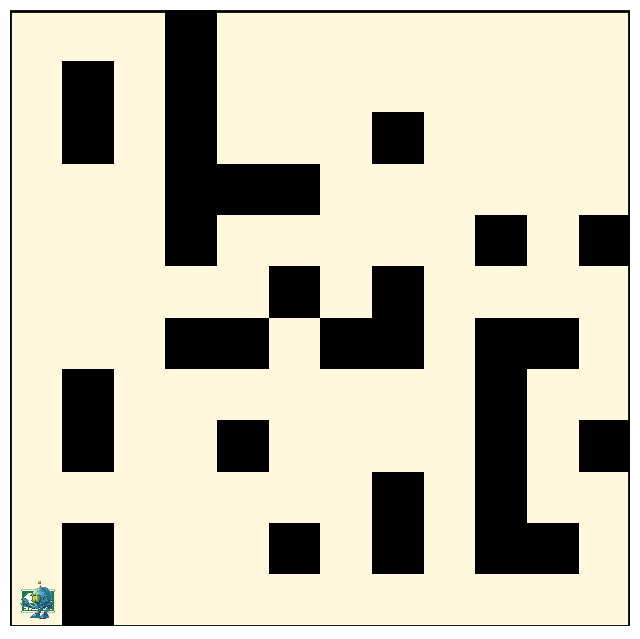

In [54]:
camino = [(0,3), (0,2), (0,1), (0,0)]
lab.pintar_camino(camino)

**Ejercicio 10:**

Resuelva el problema del laberinto iniciando en la casilla $(11,11)$ mediante los cuatro métodos `breadth_first_search`, `depth_first_search`, `iterative_deepening_search` y `best_first_search` con la función de costo uniforme. ¿Cuál es más rápido? ¿Cuál da una solución óptima?

In [55]:
inicia = (11,11)
lab = Laberinto(inicia)
s = lab.estado_inicial
lab.pintar_estado(s)

<AxesSubplot:>

In [77]:
fbreadth = breadth_first_search(lab)

KeyboardInterrupt: 

In [66]:
found = depth_limited_search(lab, 40)
if found is not None:
    if found == 'cutoff':
        print("Sin solución")
    else:
        camino = solucion(found)
        print("Solución {}".format(camino))
else: 
    print('Sin solución definitiva')

Solución [(11, 10), (11, 9), (11, 8), (10, 8), (10, 9), (10, 10), (10, 11), (9, 11), (9, 10), (9, 9), (9, 8), (8, 8), (8, 9), (8, 10), (8, 11), (7, 11), (7, 10), (6, 10), (6, 11), (5, 11), (5, 10), (5, 9), (6, 9), (6, 8), (6, 7), (5, 7), (4, 7), (4, 6), (3, 6), (2, 6), (2, 7), (1, 7), (1, 6), (1, 5), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 0)]


In [70]:
l = iterative_deepening_search(lab, 40)

if l is not None:
    camino = solucion(l)
    print("Solución encontrada: ", camino)
else:
    print("No hay solución.")

Profundidad máxima: 0
Profundidad máxima: 1
Profundidad máxima: 2
Profundidad máxima: 3
Profundidad máxima: 4
Profundidad máxima: 5
Profundidad máxima: 6
Profundidad máxima: 7
Profundidad máxima: 8
Profundidad máxima: 9
Profundidad máxima: 10
Profundidad máxima: 11
Profundidad máxima: 12
Profundidad máxima: 13
Profundidad máxima: 14
Profundidad máxima: 15
Profundidad máxima: 16
Profundidad máxima: 17
Profundidad máxima: 18
Profundidad máxima: 19
Profundidad máxima: 20
Profundidad máxima: 21
Profundidad máxima: 22
Solución encontrada:  [(11, 10), (11, 9), (11, 8), (10, 8), (10, 7), (10, 6), (9, 6), (8, 6), (8, 5), (8, 4), (8, 3), (7, 3), (6, 3), (6, 2), (5, 2), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


In [73]:
found_bfs = best_first_search(lab)
if found is not None:
    camino = solucion(found_bfs)
    print("Solución: {}".format(camino))
else: 
    print('Sin solución definitiva')

Solución: [(11, 10), (11, 9), (11, 8), (10, 8), (10, 7), (10, 6), (9, 6), (8, 6), (8, 5), (8, 4), (7, 4), (6, 4), (5, 4), (4, 4), (3, 4), (3, 3), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


El más rápido es best_first_search, con una solución óptima.

iterative_deepening_search también da una solución óptima, sin embargo no es rápido.

depth_first_search da una solución muy mala.

breadth_first_search nunca terminó.  

---

## En este notebook usted aprendió

* Cómo realizar una búsqueda mediante los métodos *depth_limited* e *iterative_deepening* e implementarlos en python.
* Cómo implementar una lista prioritaria en Python.
* La incorporación del costo de las acciones y el costo del camino asociado a un nodo en un árbol de búsqueda.
